In [20]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import torch.optim as optim
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc


Data Preparation and Preprocessing

In [2]:
import os
import shutil

# kaggle.json
'''os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
import zipfile

with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", 'r') as zip_ref:
    zip_ref.extractall("stanford_cars")'''


Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Colab일 경우
'''
from google.colab import files
files.upload()  # kaggle.json

# kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download data from Kaggle
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# upzip
!unzip stanford-car-dataset-by-classes-folder.zip -d ./stanford_cars'''

'\nfrom google.colab import files\nfiles.upload()  # kaggle.json 파일 업로드하기!\n\n# kaggle.json을 ~/.kaggle에 옮기기\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n# Kaggle 데이터 다운로드\n!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder\n\n# 압축 풀기\n!unzip stanford-car-dataset-by-classes-folder.zip -d ./stanford_cars'

In [62]:
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch

# Train only reinforcement applied
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='stanford_cars/car_data/train',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root='stanford_cars/car_data/test',
    transform=transform
)

# Check class names
train_classes = train_dataset.classes
test_classes = test_dataset.classes
#print("Train classes:", train_classes)
#print("Test classes:", test_classes)

# Get test indices by class
test_class_indices = defaultdict(list)
for i, (img, label) in enumerate(test_dataset):
    class_name = test_dataset.classes[label]
    test_class_indices[class_name].append(i)

# Split test set: 20 for val, rest for test
val_indices = []
final_test_indices = []

for class_name in test_classes:
    samples = test_class_indices[class_name]
    val_indices += samples[:20]
    final_test_indices += samples[20:]

# Create Subsets
val_dataset = Subset(test_dataset, val_indices)
test_dataset = Subset(test_dataset, final_test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
print("Validation set size:", len(val_dataset))
print("Validation loader length (batches):", len(val_loader))

Validation set size: 3920
Validation loader length (batches): 123


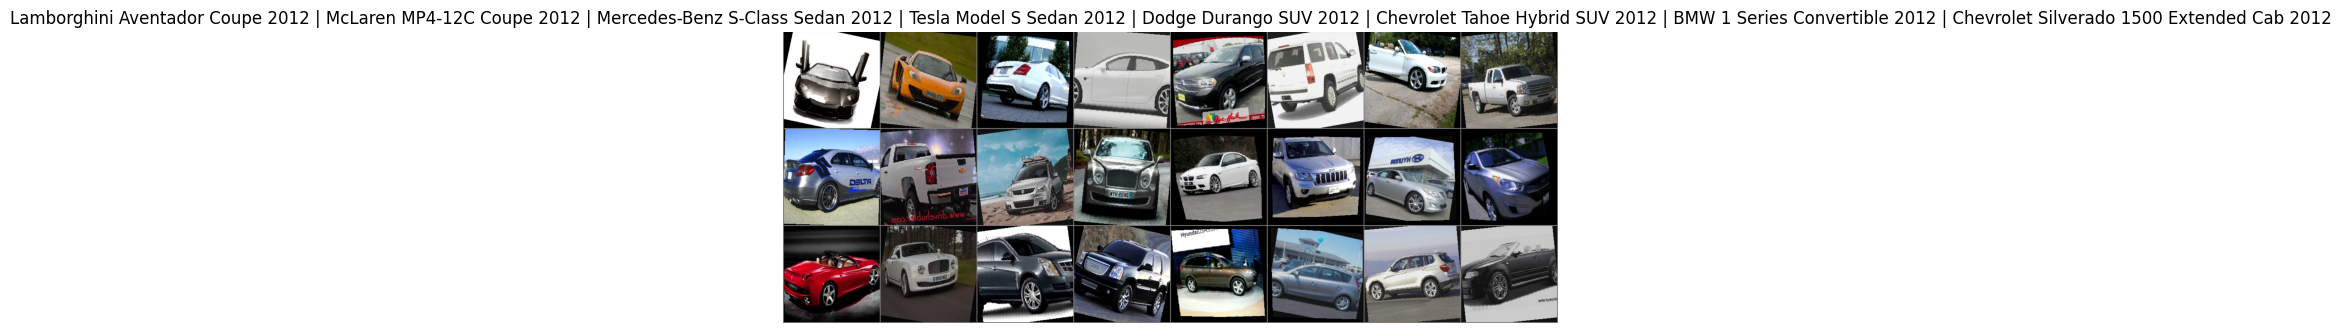

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get class name
class_names = train_dataset.classes

# Get only one image from DataLoader
images, labels = next(iter(train_loader))

# Defining image visualization functions
def imshow(img, title):
    img = img / 2 + 0.5  # de-normalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize 8 samples
imshow(torchvision.utils.make_grid(images[:24]),
       title=' | '.join([class_names[labels[i]] for i in range(8)]))


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple CNN model

In [16]:
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Input channels: 3 (RGB) → Output: 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # MaxPool 2x2: halves the spatial size
        self.pool = nn.MaxPool2d(2, 2)

        # Second conv: input 32 → output 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.dropout = nn.Dropout(0.25)

        # The last feature map is [64 channels, 56, 56]
        # When flattened, it is 64 * 56 * 56 = 200704 dimensions
        self.fc1 = nn.Linear(64 * 56 * 56, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, num_classes)   # Final output layer

    def forward(self, x):

        # conv1 → [B, 32, 224, 224]
        x = self.conv1(x)
        x = F.relu(x)

        # pool → [B, 32, 112, 112]
        x = self.pool(x)

        # conv2 → [B, 64, 112, 112]
        x = self.conv2(x)
        x = F.relu(x)

        # pool → [B, 64, 56, 56]
        x = self.pool(x)

        x = self.dropout(x)

        # Flatten: [B, 64 * 56 * 56] = [B, 200704]
        x = x.view(x.size(0), -1)

        # fc1 → [B, 256]
        x = F.relu(self.fc1(x))

        # fc2 → [B, num_classes]
        x = self.fc2(x)

        return x



In [18]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=196).to(device)

criterion = nn.CrossEntropyLoss()               # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 

In [19]:
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()                   # Initialize slope
        outputs = model(images)                 # Pridict
        loss = criterion(outputs, labels)       # Loss calculation
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Weight update

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    # -----------------------------
    # Validation phase
    # -----------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No backprop for validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # -----------------------------
    # Print results
    # -----------------------------
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/10, Train Loss: 5.3726, Train Acc: 0.37%, Val Loss: 5.2787, Val Acc: 0.54%
Epoch 2/10, Train Loss: 5.2615, Train Acc: 0.61%, Val Loss: 5.2107, Val Acc: 0.97%
Epoch 3/10, Train Loss: 5.1815, Train Acc: 1.22%, Val Loss: 5.1633, Val Acc: 0.97%
Epoch 4/10, Train Loss: 5.1262, Train Acc: 1.62%, Val Loss: 5.1503, Val Acc: 1.17%
Epoch 5/10, Train Loss: 5.0847, Train Acc: 2.09%, Val Loss: 5.1337, Val Acc: 1.66%
Epoch 6/10, Train Loss: 5.0460, Train Acc: 2.55%, Val Loss: 5.1097, Val Acc: 1.99%
Epoch 7/10, Train Loss: 5.0094, Train Acc: 2.87%, Val Loss: 5.1332, Val Acc: 1.86%
Epoch 8/10, Train Loss: 4.9803, Train Acc: 2.76%, Val Loss: 5.1285, Val Acc: 2.32%
Epoch 9/10, Train Loss: 4.9288, Train Acc: 3.46%, Val Loss: 5.1216, Val Acc: 2.04%
Epoch 10/10, Train Loss: 4.8985, Train Acc: 3.59%, Val Loss: 5.1518, Val Acc: 2.35%


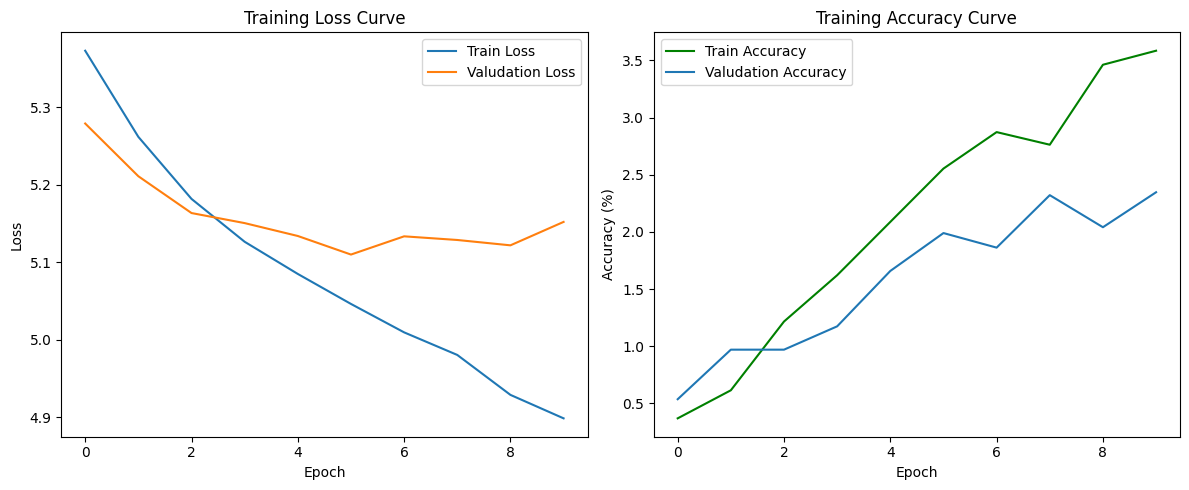

In [20]:
# Loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valudation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Valudation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model.eval()  # Test is in evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)
        test_loss += criterion(test_outputs, test_labels).item()

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        all_preds.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"\n✅ Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



✅ Test Loss: 5.1432, Test Accuracy: 2.38%


<Figure size 1000x1000 with 0 Axes>

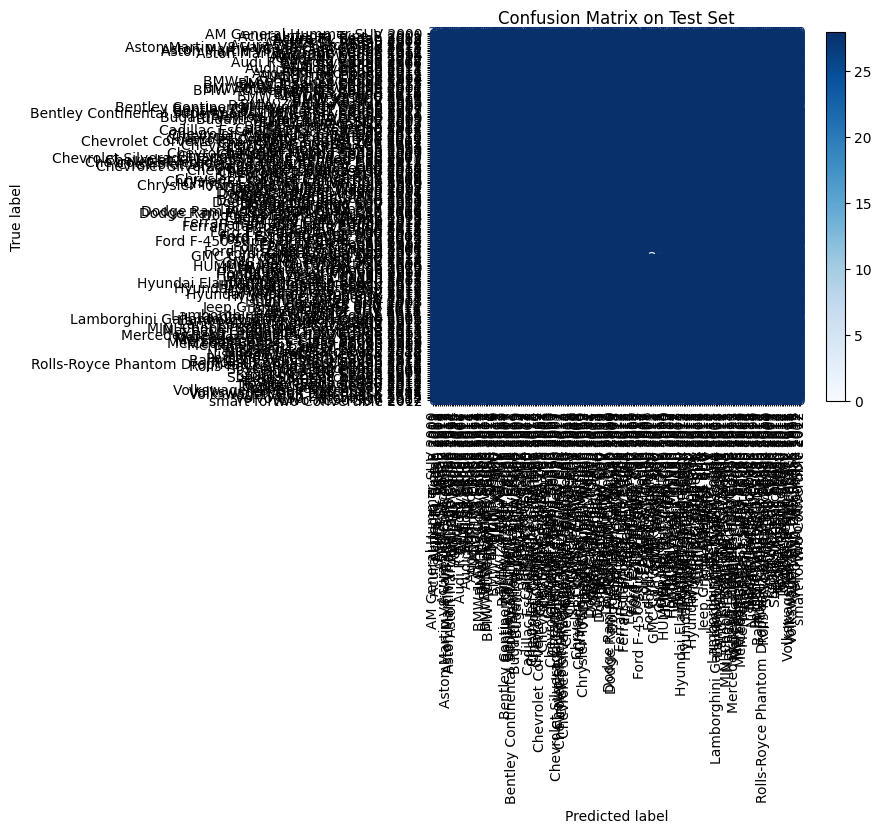

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.dataset.classes)

plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix on Test Set")
plt.show()


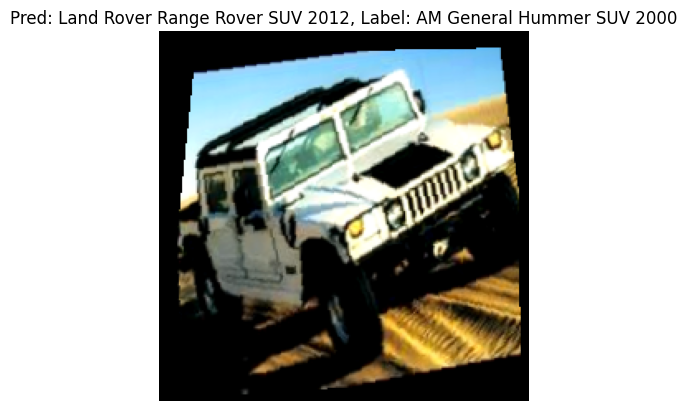

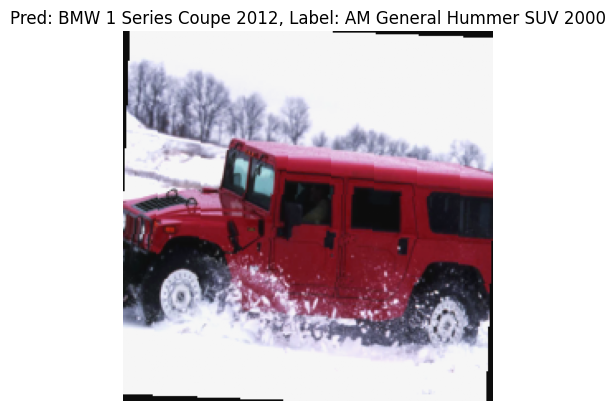

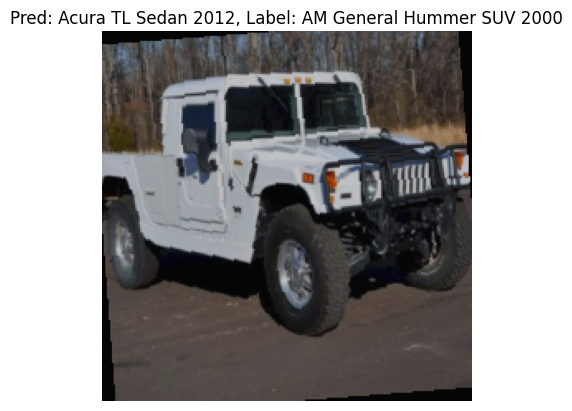

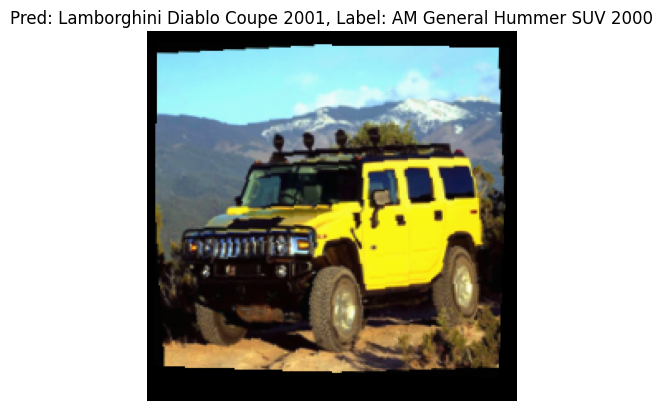

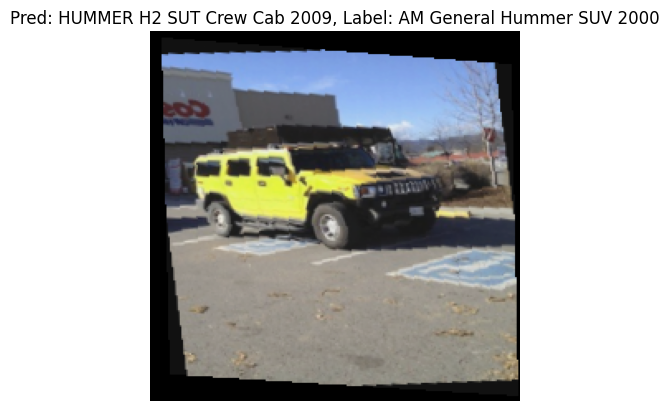

In [23]:
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show some image predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Output the first 5 images
for i in range(5):
    imshow(images[i].cpu(), f"Pred: {test_dataset.dataset.classes[predicted[i]]}, Label: {test_dataset.dataset.classes[labels[i]]}")


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the last layer (fc) with your number of classes
num_classes = 196  # Set your number of classes
in_features = model.fc.in_features  #  Number of input features to final fc
model.fc = nn.Linear(in_features, num_classes)  #  Define new final layer

# Move model to selected device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()                         #  Cross-entropy for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)      # Using Adam optimizer


In [33]:
# List for records
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
all_val_probs, all_val_labels = [], []

num_epochs = 20
# Learning 
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(100 * correct / total)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    
    # validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    epoch_val_probs, epoch_val_targets = [], []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)

            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            probs = torch.softmax(val_outputs, dim=1)
            epoch_val_probs.extend(probs.cpu().numpy())
            epoch_val_targets.extend(val_labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(100 * val_correct / val_total)
    all_val_probs.extend(epoch_val_probs)
    all_val_labels.extend(epoch_val_targets)

     # -----------------------------
    # Output the results
    # -----------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")



Epoch [1/20], Loss: 1.3451, Accuracy: 0.85%
Epoch [1/20] | Train Loss: 1.3451, Train Acc: 0.85% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [2/20], Loss: 1.3451, Accuracy: 1.39%
Epoch [2/20] | Train Loss: 1.3451, Train Acc: 1.39% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [3/20], Loss: 1.3451, Accuracy: 2.37%
Epoch [3/20] | Train Loss: 1.3451, Train Acc: 2.37% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [4/20], Loss: 1.3451, Accuracy: 4.86%
Epoch [4/20] | Train Loss: 1.3451, Train Acc: 4.86% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [5/20], Loss: 1.3451, Accuracy: 9.41%
Epoch [5/20] | Train Loss: 1.3451, Train Acc: 9.41% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [6/20], Loss: 1.3451, Accuracy: 15.10%
Epoch [6/20] | Train Loss: 1.3451, Train Acc: 15.10% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [7/20], Loss: 1.3451, Accuracy: 24.36%
Epoch [7/20] | Train Loss: 1.3451, Train Acc: 24.36% | Val Loss: 2.4145, Val Acc: 40.51%
Epoch [8/20], Loss: 1.3451, Accuracy: 32.45%
Epoch [8/20] | Train Loss: 

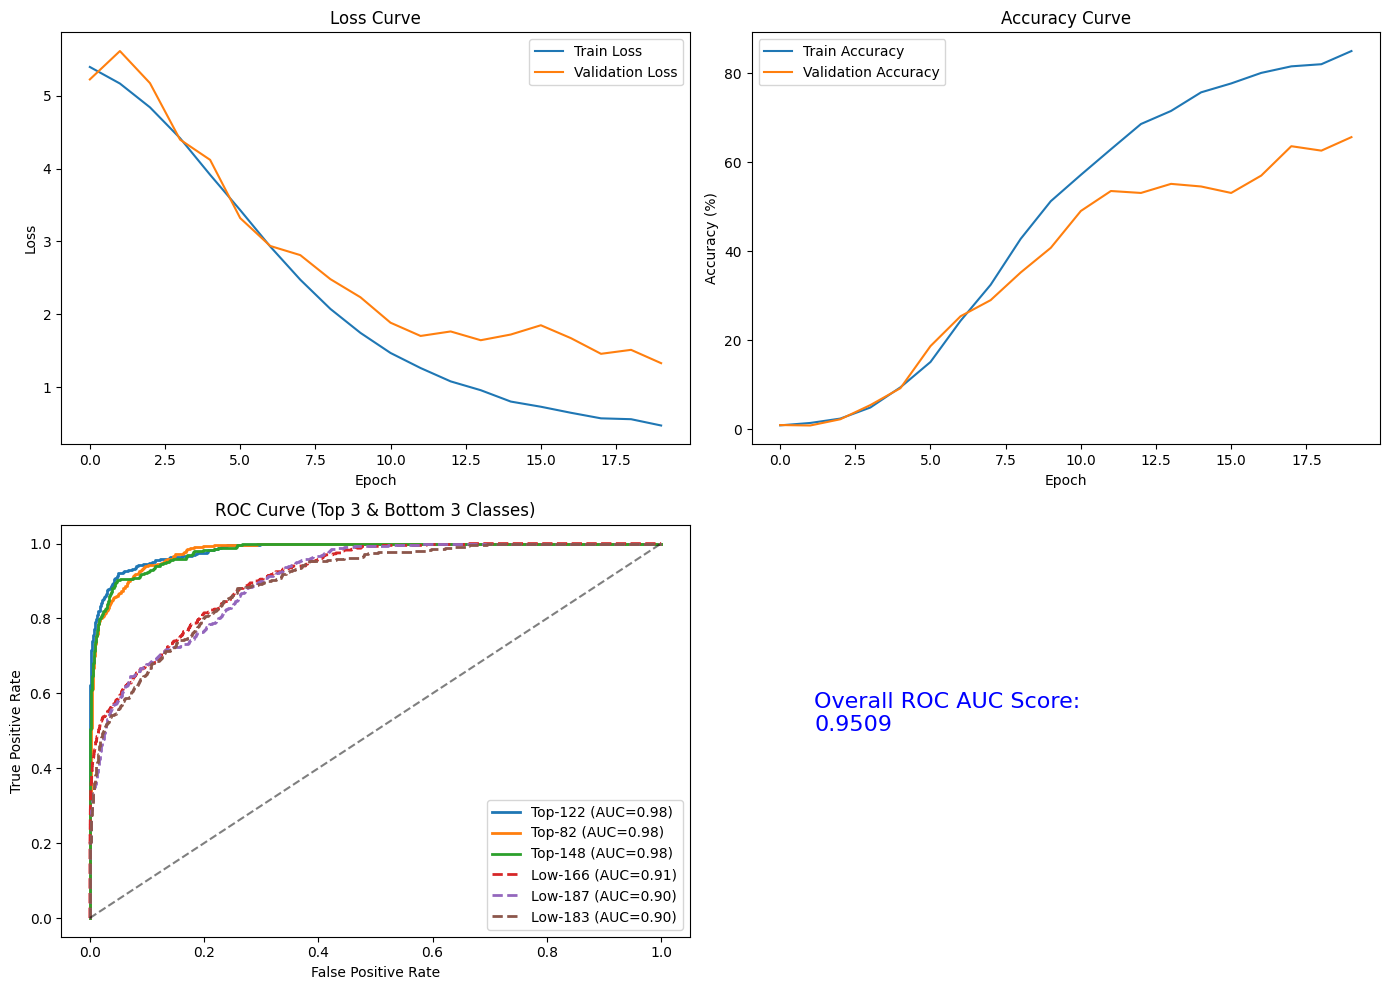

In [61]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

num_classes = len(np.unique(all_val_labels))

# Calculate AUC 
all_val_probs = np.array(all_val_probs)
all_val_labels = np.array(all_val_labels)
y_true_bin = label_binarize(all_val_labels, classes=range(num_classes))
overall_auc = roc_auc_score(y_true_bin, all_val_probs, average='macro', multi_class='ovr')

########## Visualizaion
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Loss Curve
axs[0, 0].plot(train_losses, label='Train Loss')
axs[0, 0].plot(val_losses, label='Validation Loss')
axs[0, 0].set_title('Loss Curve')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# 2. Accuracy Curve
axs[0, 1].plot(train_accuracies, label='Train Accuracy')
axs[0, 1].plot(val_accuracies, label='Validation Accuracy')
axs[0, 1].set_title('Accuracy Curve')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].legend()

# 3. ROC Curve
'''for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_val_probs[:, i])
    axs[1, 0].plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')
axs[1, 0].plot([0, 1], [0, 1], 'k--')
axs[1, 0].set_title('ROC Curve (One-vs-Rest)')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
#axs[1, 0].legend()
'''

# calculate AUC of all classes
roc_info = []  # List of (class_index, fpr, tpr, auc_score)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_val_probs[:, i])
    auc_score = auc(fpr, tpr)
    roc_info.append((i, fpr, tpr, auc_score))

# Sort classes by AUC score (descending)
roc_info_sorted = sorted(roc_info, key=lambda x: x[3], reverse=True)

# Select top 3 and bottom 3 classes
top_3 = roc_info_sorted[:3]      # Best performance
bottom_3 = roc_info_sorted[-3:]  # Worst performance

# Plot ROC curves for selected classes
axs[1, 0].set_title('ROC Curve (Top 3 & Bottom 3 Classes)')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')

# Plot top 3 classes (solid lines)
for idx, fpr, tpr, auc_score in top_3:
    axs[1, 0].plot(fpr, tpr, label=f"Top-{idx} (AUC={auc_score:.2f})", linewidth=2)

# Plot bottom 3 classes (dashed lines)
for idx, fpr, tpr, auc_score in bottom_3:
    axs[1, 0].plot(fpr, tpr, linestyle='--', label=f"Low-{idx} (AUC={auc_score:.2f})", linewidth=2)

# Reference diagonal line (random guess)
axs[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)


# Add legend
axs[1, 0].legend(loc='lower right')


# 4. Overall AUC 
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, f'Overall ROC AUC Score:\n{overall_auc:.4f}', fontsize=16, color='blue')

plt.tight_layout()
plt.show()


 Classification Report:
              precision    recall  f1-score   support

           0     0.4469    0.5575    0.4961       400
           1     0.5282    0.3750    0.4386       400
           2     0.4098    0.2100    0.2777       400
           3     0.5298    0.3775    0.4409       400
           4     0.4951    0.3775    0.4284       400
           5     0.6456    0.3325    0.4389       400
           6     0.4322    0.2950    0.3507       400
           7     0.2206    0.2575    0.2376       400
           8     0.3448    0.1750    0.2322       400
           9     0.3253    0.1350    0.1908       400
          10     0.4661    0.3950    0.4276       400
          11     0.4059    0.3075    0.3499       400
          12     0.2094    0.1675    0.1861       400
          13     0.2929    0.4050    0.3400       400
          14     0.3042    0.3650    0.3318       400
          15     0.3976    0.2525    0.3089       400
          16     0.3421    0.1950    0.2484       400
  

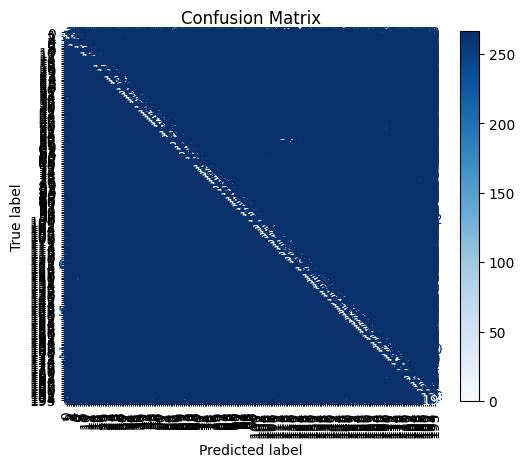

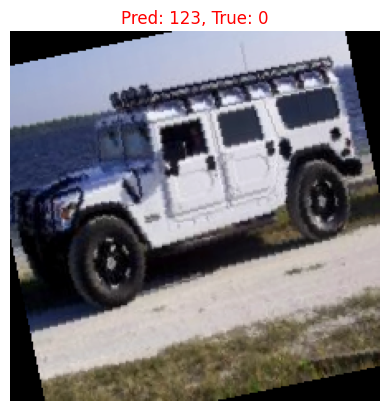

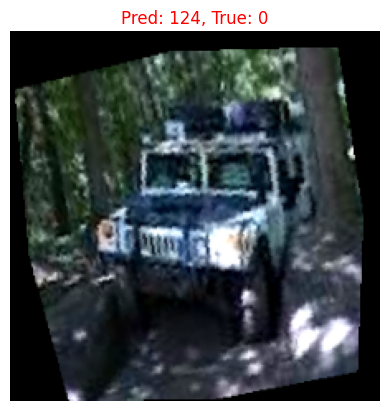

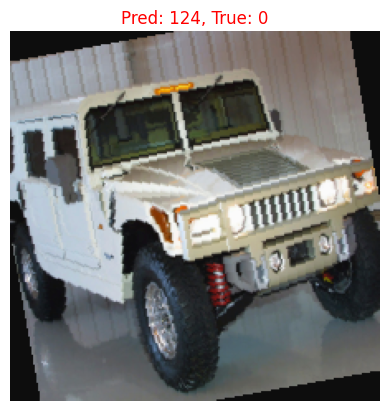

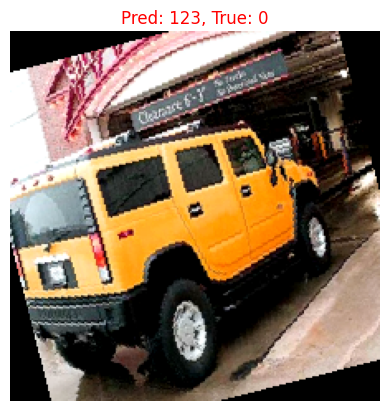

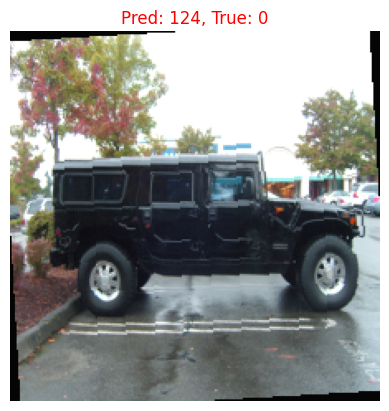

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Quantitative evaluation
print("\n Classification Report:")
preds = np.argmax(all_val_probs, axis=1)
print(classification_report(all_val_labels, preds, digits=4))

# Qualitative Analysis: Confusion Matrix Visualization
cm = confusion_matrix(all_val_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Output some incorrectly classified images
wrong_samples = []
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_samples.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))
        if len(wrong_samples) >= 5:
            break

for i in range(min(5, len(wrong_samples))):
    img, pred, true = wrong_samples[i]
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalization
    plt.imshow(img)
    plt.title(f"Pred: {pred}, True: {true}", color='red')
    plt.axis('off')
    plt.show()



 Test Accuracy: 64.72%
 Test AUC: 0.9936

 Test Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.9167    0.7719        24
           1     0.7391    0.7083    0.7234        24
           2     0.3333    0.5833    0.4242        12
           3     0.6176    0.9130    0.7368        23
           4     0.8000    0.7273    0.7619        22
           5     0.5882    0.5000    0.5405        20
           6     0.8571    0.6316    0.7273        19
           7     0.5769    0.6000    0.5882        25
           8     0.2889    0.6190    0.3939        21
           9     0.0000    0.0000    0.0000        13
          10     0.2381    0.8333    0.3704        18
          11     0.6000    0.6000    0.6000        20
          12     0.3889    0.3182    0.3500        22
          13     0.6500    0.6190    0.6341        21
          14     0.5122    0.9130    0.6562        23
          15     0.6923    0.5625    0.6207        16
         

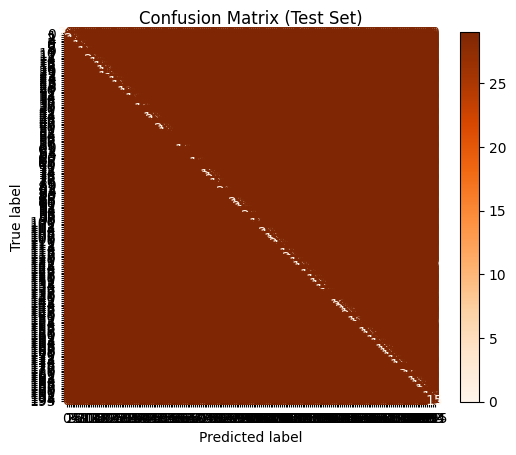

In [21]:
import numpy as np
batch_size = 40

# Test Evaluation
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\n Test Accuracy: {test_accuracy:.2f}%")

# Quantitative evaluation
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
y_test_bin = label_binarize(test_labels, classes=range(num_classes))

test_auc = roc_auc_score(y_test_bin, test_probs, average='macro', multi_class='ovr')
print(f" Test AUC: {test_auc:.4f}")

print("\n Test Classification Report:")
print(classification_report(test_labels, np.argmax(test_probs, axis=1), digits=4))

# confusion matrix
cm = confusion_matrix(test_labels, np.argmax(test_probs, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix (Test Set)")
plt.show()


# Model_v2

For product overfittng, save 

In [4]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 and modify the final layer
model_v2 = resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = 196
model_v2.fc = nn.Linear(model_v2.fc.in_features, num_classes)
model_v2 = model_v2.to(device)

# Define loss function and optimizer for model_v2
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)


In [70]:
import os
import torch
import torch.nn.functional as F

#  Make directory for saving model checkpoints
os.makedirs("models_v2", exist_ok=True)

#  Lists for recording training and validation history (v2)
train_losses_v2, val_losses_v2 = [], []
train_accuracies_v2, val_accuracies_v2 = [], []
val_probs_v2, val_labels_v2 = [], []

num_epochs = 20

for epoch in range(num_epochs):
    model_v2.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_v2.zero_grad()
        outputs = model_v2(inputs)
        loss = criterion_v2(outputs, labels)
        loss.backward()
        optimizer_v2.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    train_losses_v2.append(epoch_loss)
    train_accuracies_v2.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%")

    # Validation phase
    model_v2.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    epoch_val_probs, epoch_val_targets = [], []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_v2(val_inputs)
            loss = criterion_v2(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)

            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            probs = F.softmax(val_outputs, dim=1)
            epoch_val_probs.extend(probs.cpu().numpy())
            epoch_val_targets.extend(val_labels.cpu().numpy())

    # Validation metrics
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_losses_v2.append(avg_val_loss)
    val_accuracies_v2.append(val_accuracy)
    val_probs_v2.extend(epoch_val_probs)
    val_labels_v2.extend(epoch_val_targets)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    #  Save model at every epoch (with epoch and val acc in filename)
    save_path = f"models_v2/model_epoch_{epoch+1:02d}_valacc_{val_accuracy:.2f}.pth"
    torch.save(model_v2.state_dict(), save_path)
    print(f"Saved: {save_path}")


Epoch [1/20] | Train Loss: 5.3713, Train Acc: 0.96%
Epoch [1/20] | Train Loss: 5.3713, Train Acc: 0.96% | Val Loss: 5.2792, Val Acc: 1.61%
Saved: models_v2/model_epoch_01_valacc_1.61.pth
Epoch [2/20] | Train Loss: 4.8076, Train Acc: 3.27%
Epoch [2/20] | Train Loss: 4.8076, Train Acc: 3.27% | Val Loss: 5.0594, Val Acc: 3.06%
Saved: models_v2/model_epoch_02_valacc_3.06.pth
Epoch [3/20] | Train Loss: 4.0559, Train Acc: 8.60%
Epoch [3/20] | Train Loss: 4.0559, Train Acc: 8.60% | Val Loss: 4.0076, Val Acc: 9.21%
Saved: models_v2/model_epoch_03_valacc_9.21.pth
Epoch [4/20] | Train Loss: 3.3295, Train Acc: 17.94%
Epoch [4/20] | Train Loss: 3.3295, Train Acc: 17.94% | Val Loss: 3.1031, Val Acc: 21.79%
Saved: models_v2/model_epoch_04_valacc_21.79.pth
Epoch [5/20] | Train Loss: 2.7044, Train Acc: 29.99%
Epoch [5/20] | Train Loss: 2.7044, Train Acc: 29.99% | Val Loss: 2.9702, Val Acc: 26.94%
Saved: models_v2/model_epoch_05_valacc_26.94.pth
Epoch [6/20] | Train Loss: 2.1317, Train Acc: 41.43%
Epoc

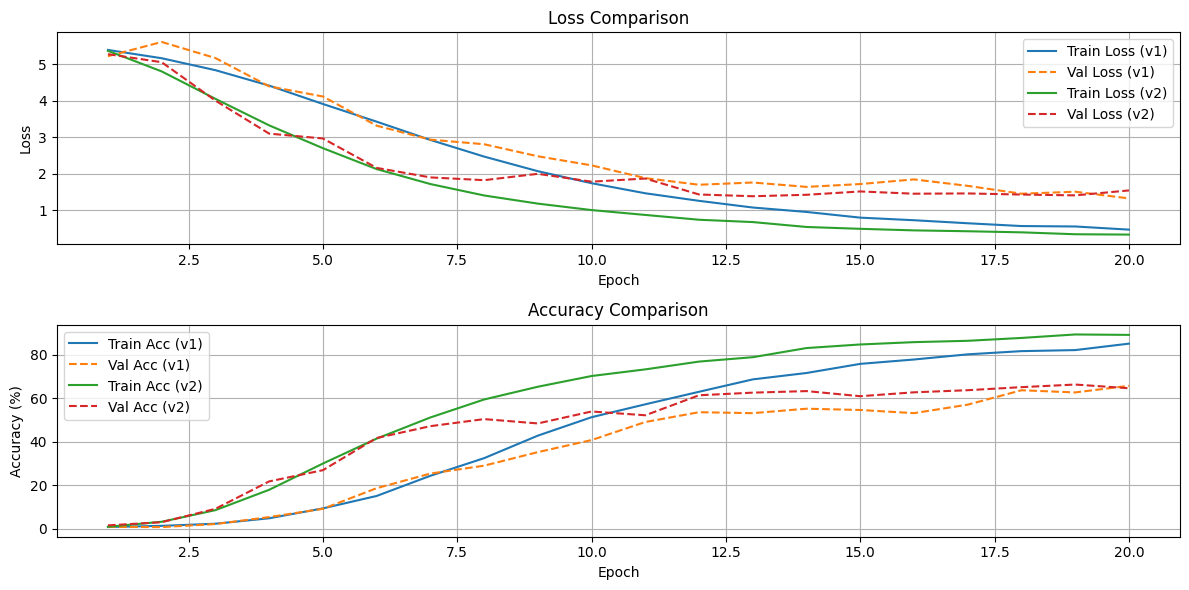

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# 🔹 Loss Curve
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss (v1)', linestyle='-')
plt.plot(epochs, val_losses, label='Val Loss (v1)', linestyle='--')
plt.plot(epochs, train_losses_v2, label='Train Loss (v2)', linestyle='-')
plt.plot(epochs, val_losses_v2, label='Val Loss (v2)', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🔹 Accuracy Curve
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, label='Train Acc (v1)', linestyle='-')
plt.plot(epochs, val_accuracies, label='Val Acc (v1)', linestyle='--')
plt.plot(epochs, train_accuracies_v2, label='Train Acc (v2)', linestyle='-')
plt.plot(epochs, val_accuracies_v2, label='Val Acc (v2)', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
# Load Model
model_v2.load_state_dict(torch.load('models_v2/model_epoch_13_valacc_62.53.pth'))
model_v2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

test dataset


 Test Accuracy: 64.26%
 Test AUC: 0.9936

 Test Classification Report:


C:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

              precision    recall  f1-score   support

           0     0.8077    0.8750    0.8400        24
           1     0.8333    0.8333    0.8333        24
           2     0.2222    0.6667    0.3333        12
           3     0.8500    0.7391    0.7907        23
           4     0.8889    0.7273    0.8000        22
           5     0.5909    0.6500    0.6190        20
           6     0.8333    0.5263    0.6452        19
           7     0.3148    0.6800    0.4304        25
           8     0.3636    0.1905    0.2500        21
           9     0.2500    0.0769    0.1176        13
          10     0.5238    0.6111    0.5641        18
          11     0.3000    0.1500    0.2000        20
          12     0.2553    0.5455    0.3478        22
          13     0.5714    0.5714    0.5714        21
          14     0.7500    0.6522    0.6977        23
          15     0.8462    0.6875    0.7586        16
          16     0.8333    0.6000    0.6977        25
          17     0.4000    

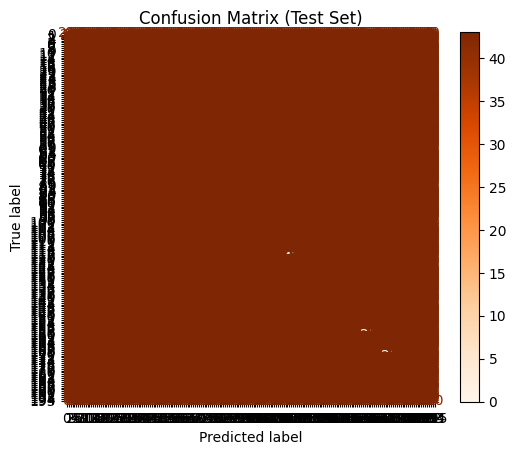

In [24]:
import numpy as np
batch_size = 40

# Test Evaluation
model_v2.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_v2(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\n Test Accuracy: {test_accuracy:.2f}%")

# Quantitative evaluation
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
y_test_bin = label_binarize(test_labels, classes=range(num_classes))

test_auc = roc_auc_score(y_test_bin, test_probs, average='macro', multi_class='ovr')
print(f" Test AUC: {test_auc:.4f}")

print("\n Test Classification Report:")
print(classification_report(test_labels, np.argmax(test_probs, axis=1), digits=4))

# confusion matrix
cm = confusion_matrix(test_labels, np.argmax(test_probs, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix (Test Set)")
plt.show()


Model_v3

To enhance stability and prevent overfitting, we used ReduceLROnPlateau to dynamically reduce the learning rate based on validation loss performance.

In [65]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 and modify the final layer
model_v3 = resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = 196
model_v3.fc = nn.Linear(model_v3.fc.in_features, num_classes)
model_v3 = model_v3.to(device)

# Define loss function and optimizer for model_v3
criterion_v3 = nn.CrossEntropyLoss()
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.001)


In [66]:
import os
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

#  Make directory for saving model checkpoints
os.makedirs("models_v3", exist_ok=True)

#  Lists for recording training and validation history (v3)
train_losses_v3, val_losses_v3 = [], []
train_accuracies_v3, val_accuracies_v3 = [], []
val_probs_v3, val_labels_v3 = [], []

# Define scheduler to reduce learning rate when validation loss plateaus
scheduler_v3 = ReduceLROnPlateau(optimizer_v3, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 20

for epoch in range(num_epochs):
    model_v3.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_v3.zero_grad()
        outputs = model_v3(inputs)
        loss = criterion_v3(outputs, labels)
        loss.backward()
        optimizer_v3.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    train_losses_v3.append(epoch_loss)
    train_accuracies_v3.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%")

    # Validation phase
    model_v3.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    epoch_val_probs, epoch_val_targets = [], []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_v3(val_inputs)
            loss = criterion_v3(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)

            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            probs = F.softmax(val_outputs, dim=1)
            epoch_val_probs.extend(probs.cpu().numpy())
            epoch_val_targets.extend(val_labels.cpu().numpy())

    # Validation metrics
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_losses_v3.append(avg_val_loss)
    val_accuracies_v3.append(val_accuracy)
    val_probs_v3.extend(epoch_val_probs)
    val_labels_v3.extend(epoch_val_targets)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss
    scheduler_v3.step(avg_val_loss)

    #  Save model at every epoch (with epoch and val acc in filename)
    save_path = f"models_v3/model_epoch_{epoch+1:02d}_valacc_{val_accuracy:.2f}.pth"
    torch.save(model_v3.state_dict(), save_path)
    print(f"Saved: {save_path}")


Epoch [1/20] | Train Loss: 5.4470, Train Acc: 0.54%
Epoch [1/20] | Train Loss: 5.4470, Train Acc: 0.54% | Val Loss: 6.2261, Val Acc: 0.51%
Saved: models_v3/model_epoch_01_valacc_0.51.pth
Epoch [2/20] | Train Loss: 5.2709, Train Acc: 0.88%
Epoch [2/20] | Train Loss: 5.2709, Train Acc: 0.88% | Val Loss: 5.1875, Val Acc: 1.15%
Saved: models_v3/model_epoch_02_valacc_1.15.pth
Epoch [3/20] | Train Loss: 5.1573, Train Acc: 1.40%
Epoch [3/20] | Train Loss: 5.1573, Train Acc: 1.40% | Val Loss: 5.2658, Val Acc: 1.89%
Saved: models_v3/model_epoch_03_valacc_1.89.pth
Epoch [4/20] | Train Loss: 5.0445, Train Acc: 2.04%
Epoch [4/20] | Train Loss: 5.0445, Train Acc: 2.04% | Val Loss: 5.0898, Val Acc: 2.02%
Saved: models_v3/model_epoch_04_valacc_2.02.pth
Epoch [5/20] | Train Loss: 4.8489, Train Acc: 2.80%
Epoch [5/20] | Train Loss: 4.8489, Train Acc: 2.80% | Val Loss: 4.9364, Val Acc: 2.93%
Saved: models_v3/model_epoch_05_valacc_2.93.pth
Epoch [6/20] | Train Loss: 4.5339, Train Acc: 4.76%
Epoch [6/20] 


 Test Accuracy: 55.01%
 Test AUC: 0.9889

 Test Classification Report:
              precision    recall  f1-score   support

           0     0.9333    0.5833    0.7179        24
           1     0.5217    0.5000    0.5106        24
           2     0.3846    0.4167    0.4000        12
           3     0.6667    0.2609    0.3750        23
           4     0.4800    0.5455    0.5106        22
           5     0.8333    0.2500    0.3846        20
           6     0.3077    0.8421    0.4507        19
           7     0.4706    0.3200    0.3810        25
           8     0.4167    0.2381    0.3030        21
           9     0.2609    0.4615    0.3333        13
          10     0.3793    0.6111    0.4681        18
          11     0.3333    0.0500    0.0870        20
          12     0.3571    0.2273    0.2778        22
          13     0.3913    0.8571    0.5373        21
          14     0.7059    0.5217    0.6000        23
          15     0.5385    0.4375    0.4828        16
         

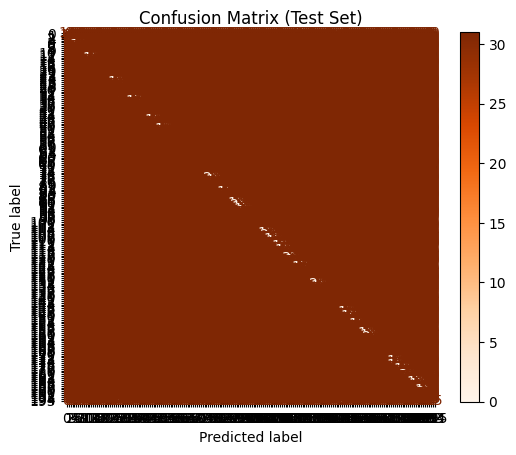

In [67]:
import numpy as np
batch_size = 32

# Test Evaluation
model_v3.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_v3(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\n Test Accuracy: {test_accuracy:.2f}%")

# Quantitative evaluation
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
y_test_bin = label_binarize(test_labels, classes=range(num_classes))

test_auc = roc_auc_score(y_test_bin, test_probs, average='macro', multi_class='ovr')
print(f" Test AUC: {test_auc:.4f}")

print("\n Test Classification Report:")
print(classification_report(test_labels, np.argmax(test_probs, axis=1), digits=4))

# confusion matrix
cm = confusion_matrix(test_labels, np.argmax(test_probs, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix (Test Set)")
plt.show()


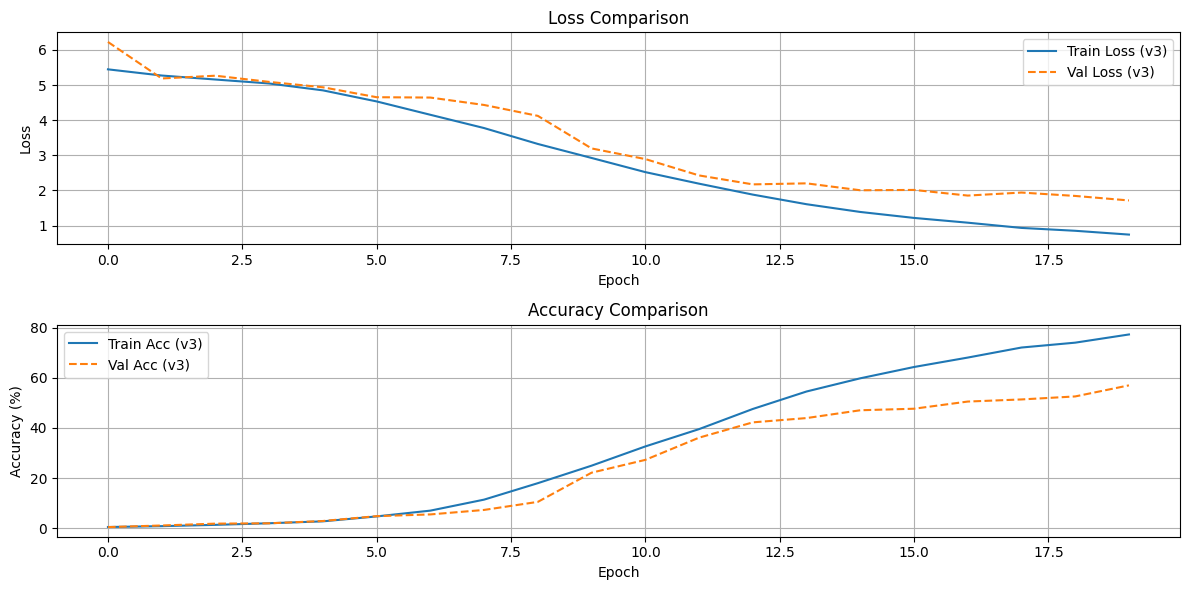

In [68]:
import matplotlib.pyplot as plt

epochs = range(20) #range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# 🔹 Loss Curve
plt.subplot(2, 1, 1)
#plt.plot(epochs, train_losses, label='Train Loss (v1)', linestyle='-')
#plt.plot(epochs, val_losses, label='Val Loss (v1)', linestyle='--')
plt.plot(epochs, train_losses_v3, label='Train Loss (v3)', linestyle='-')
plt.plot(epochs, val_losses_v3, label='Val Loss (v3)', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🔹 Accuracy Curve
plt.subplot(2, 1, 2)
#plt.plot(epochs, train_accuracies, label='Train Acc (v1)', linestyle='-')
#plt.plot(epochs, val_accuracies, label='Val Acc (v1)', linestyle='--')
plt.plot(epochs, train_accuracies_v3, label='Train Acc (v3)', linestyle='-')
plt.plot(epochs, val_accuracies_v3, label='Val Acc (v3)', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Visualization & Apply 

Model - v1

In [42]:
import requests

def get_vehicle_market_value(year, make, model, state='CA', mileage=30000):
    # Vehicle model blank handling
    model_encoded = model.replace(' ', '%20')

    # URL 
    url = f"https://api.vehicledatabases.com/market-value/v2/ymm/{year}/{make}/{model_encoded}?state={state}&mileage={mileage}"

    # API Key
    headers = {
        'x-AuthKey': '96bc8c0012a311f08d010242ac120002'  
    }

    # Send Request
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f" API request failed: {response.status_code} - {response.text}")
        return

    data = response.json()

    print(f"\n Expected price (Make: {make}, Model: {model}, Year: {year}, Mileage: {mileage}, State: {state})")

    for trim_data in data['data']['market_value']['market_value_data']:
        print(f"\n** Trim: {trim_data['trim']}")
        for price_info in trim_data['market value']:
            print(f"  - {price_info['Condition']}:")
            print(f"    • Trade-In: {price_info['Trade-In']}")
            print(f"    • Private Party: {price_info['Private Party']}")
            print(f"    • Dealer Retail: {price_info['Dealer Retail']}")




In [26]:
import re

def parse_vehicle_string(vehicle_str):
    """
    Separate year, make, model from vehicle strings
    Example: "Dodge Caliber Wagon 2007" → make=Dodge, model=Caliber, year=2007
    """
    # Extract year
    match = re.search(r'\b(19|20)\d{2}\b', vehicle_str)
    if not match:
        raise ValueError("The year could not be found.")

    year = int(match.group())
    parts = vehicle_str.replace(str(year), '').strip().split()

    make = parts[0]
    model = parts[1]

    return year, make, model

def run_vehicle_value_lookup(vehicle_str, mileage=80000, state='CA'):
    year, make, model = parse_vehicle_string(vehicle_str)
    get_vehicle_market_value(year=year, make=make, model=model, mileage=mileage, state=state)



In this project, we aim to identify the car model from a single image using a deep learning classification model trained on the Stanford Cars dataset. However, the current model's prediction accuracy is not fully satisfactory, especially when evaluated on unseen test data. Various factors such as lighting, angle, background noise, and inter-class similarity may cause misclassification.

To compensate for this limitation, we apply a voting-based strategy inspired by ensemble learning. Instead of relying on a single prediction, we create multiple augmented versions of the same image (e.g., rotation, flipping, color distortion) and run inference on each. The most frequently predicted class among them is selected as the final output.

This method enhances the stability and reliability of predictions and is especially practical in real-world scenarios where users often upload several photos of the same vehicle from different perspectives. By aggregating multiple predictions, this approach helps improve accuracy and mitigate occasional misclassifications.

In [57]:
from PIL import Image
import random
from collections import Counter
import torchvision.transforms as transforms
import torch
import numpy as np

# 1. Pick a random index from the subset
idx = random.randint(0, len(test_dataset) - 1)

# 2. Get the file path of the original image
image_path, label = test_dataset.dataset.samples[test_dataset.indices[idx]]  # image_path = raw path
original_img = Image.open(image_path).convert("RGB")  # Force PIL RGB image

# 3. Define augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Apply transform 5 times
augmented_images = [augment_transform(original_img).unsqueeze(0).to(device) for _ in range(5)]

# 5. Predict
model.eval()
preds = []
with torch.no_grad():
    for aug_img in augmented_images:
        output = model(aug_img)
        _, pred = torch.max(output, 1)
        preds.append(pred.item())



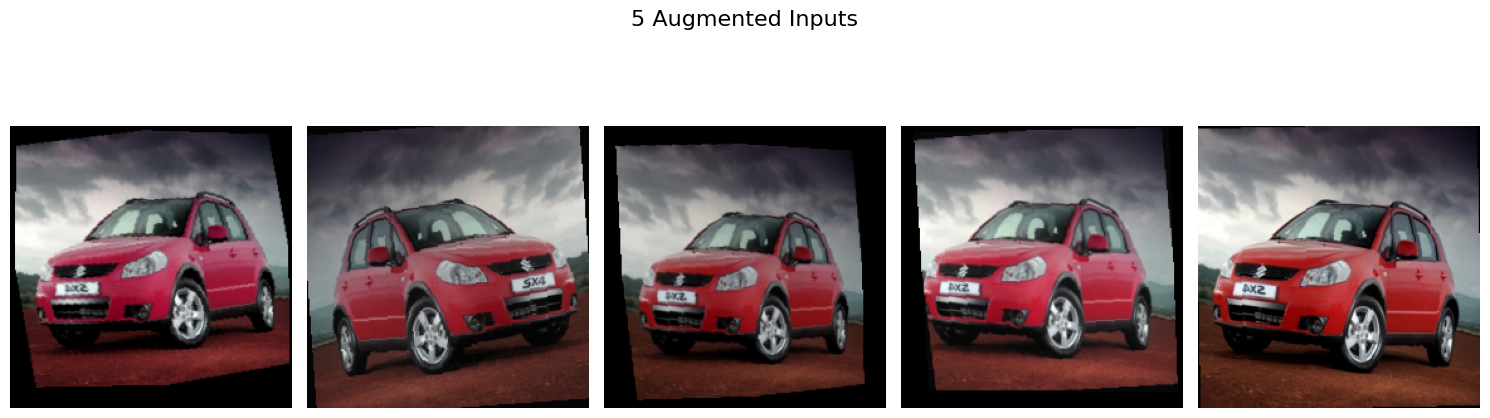


 Predictions for Each Augmented Image:
Image 1 predicted: Toyota Corolla Sedan 2012
Image 2 predicted: Suzuki SX4 Hatchback 2012
Image 3 predicted: Suzuki SX4 Hatchback 2012
Image 4 predicted: Suzuki SX4 Hatchback 2012
Image 5 predicted: Suzuki SX4 Hatchback 2012

 Majority-vote prediction (5 augmented views):
 - Predicted: Suzuki SX4 Hatchback 2012
 - Actual:    Suzuki SX4 Hatchback 2012

 Looking up market value for: Suzuki SX4 Hatchback 2012

 Expected price (Make: Suzuki, Model: SX4, Year: 2012, Mileage: 85000, State: TX)

🔹 Trim: Base 4dr Front-wheel Drive Sedan Manual
  - Outstanding:
    • Trade-In: $2,291
    • Private Party: $5,194
    • Dealer Retail: $6,857
  - Clean:
    • Trade-In: $2,163
    • Private Party: $4,874
    • Dealer Retail: $6,397
  - Average:
    • Trade-In: $1,950
    • Private Party: $4,342
    • Dealer Retail: $5,629
  - Rough:
    • Trade-In: $1,674
    • Private Party: $3,649
    • Dealer Retail: $4,632

🔹 Trim: LE 4dr Front-wheel Drive Sedan Manual
  -

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor_img):
    # Unnormalize image
    img = tensor_img.cpu() * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show 5 augmented images only 
plt.figure(figsize=(15, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i+1)
    imshow(img.squeeze(0))

plt.suptitle("5 Augmented Inputs", fontsize=16)
plt.tight_layout()
plt.show()

print("\n Predictions for Each Augmented Image:")
for i, pred_idx in enumerate(preds):
    label_name = test_dataset.dataset.classes[pred_idx]
    print(f"Image {i+1} predicted: {label_name}")


# 6. Majority vote
most_common_pred = Counter(preds).most_common(1)[0][0]
pred_class_name = test_dataset.dataset.classes[most_common_pred]
true_class_name = test_dataset.dataset.classes[label]

print(f"\n Majority-vote prediction (5 augmented views):")
print(f" - Predicted: {pred_class_name}")
print(f" - Actual:    {true_class_name}")

# 7. API call
print(f"\n Looking up market value for: {pred_class_name}")
run_vehicle_value_lookup(pred_class_name, mileage=85000, state="TX")



Model_v2

In [38]:
from PIL import Image
import random
from collections import Counter
import torchvision.transforms as transforms
import torch
import numpy as np

# 1. Pick a random index from the subset
idx = random.randint(0, len(test_dataset) - 1)

# 2. Get the file path of the original image
image_path, label = test_dataset.dataset.samples[test_dataset.indices[idx]]  # image_path = raw path
original_img = Image.open(image_path).convert("RGB")  # Force PIL RGB image

# 3. Define augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225].)
])

# 4. Apply transform 5 times
augmented_images = [augment_transform(original_img).unsqueeze(0).to(device) for _ in range(5)]

# 5. Predict
model.eval()
preds = []
with torch.no_grad():
    for aug_img in augmented_images:
        output = model_v2(aug_img)
        _, pred = torch.max(output, 1)
        preds.append(pred.item())



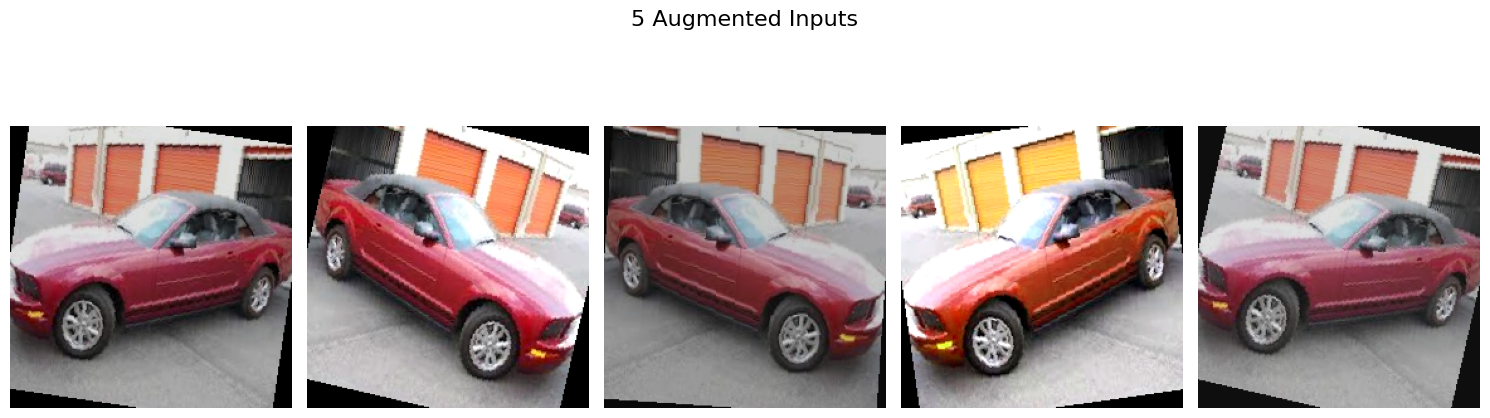


 Predictions for Each Augmented Image:
Image 1 predicted: Ford Mustang Convertible 2007
Image 2 predicted: Ford Mustang Convertible 2007
Image 3 predicted: Ford Mustang Convertible 2007
Image 4 predicted: Ford Mustang Convertible 2007
Image 5 predicted: Ford Mustang Convertible 2007

 Majority-vote prediction (5 augmented views):
 - Predicted: Ford Mustang Convertible 2007
 - Actual:    Ford Mustang Convertible 2007

 Looking up market value for: Ford Mustang Convertible 2007

 Expected price (Make: Ford, Model: Mustang, Year: 2007, Mileage: 85000, State: TX)

🔹 Trim: GT Deluxe 2dr Convertible Manual
  - Outstanding:
    • Trade-In: $5,734
    • Private Party: $9,261
    • Dealer Retail: $11,381
  - Clean:
    • Trade-In: $5,412
    • Private Party: $8,658
    • Dealer Retail: $10,543
  - Average:
    • Trade-In: $4,874
    • Private Party: $7,653
    • Dealer Retail: $9,148
  - Rough:
    • Trade-In: $4,176
    • Private Party: $6,346
    • Dealer Retail: $7,335

🔹 Trim: V6 Deluxe 2d

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor_img):
    # Unnormalize image
    img = tensor_img.cpu() * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show 5 augmented images only 
plt.figure(figsize=(15, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i+1)
    imshow(img.squeeze(0))

plt.suptitle("5 Augmented Inputs", fontsize=16)
plt.tight_layout()
plt.show()

print("\n Predictions for Each Augmented Image:")
for i, pred_idx in enumerate(preds):
    label_name = test_dataset.dataset.classes[pred_idx]
    print(f"Image {i+1} predicted: {label_name}")


# 6. Majority vote
most_common_pred = Counter(preds).most_common(1)[0][0]
pred_class_name = test_dataset.dataset.classes[most_common_pred]
true_class_name = test_dataset.dataset.classes[label]

print(f"\n Majority-vote prediction (5 augmented views):")
print(f" - Predicted: {pred_class_name}")
print(f" - Actual:    {true_class_name}")

# 7. API call
print(f"\n Looking up market value for: {pred_class_name}")
run_vehicle_value_lookup(pred_class_name, mileage=85000, state="TX")



Model v3

In [81]:
from PIL import Image
import random
from collections import Counter
import torchvision.transforms as transforms
import torch
import numpy as np

# 1. Pick a random index from the subset
idx = random.randint(0, len(test_dataset) - 1)

# 2. Get the file path of the original image
image_path, label = test_dataset.dataset.samples[test_dataset.indices[idx]]  # image_path = raw path
original_img = Image.open(image_path).convert("RGB")  # Force PIL RGB image

# 3. Define augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Apply transform 5 times
augmented_images = [augment_transform(original_img).unsqueeze(0).to(device) for _ in range(5)]

# 5. Predict
model.eval()
preds = []
with torch.no_grad():
    for aug_img in augmented_images:
        output = model_v3(aug_img)
        _, pred = torch.max(output, 1)
        preds.append(pred.item())



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4016994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5934205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


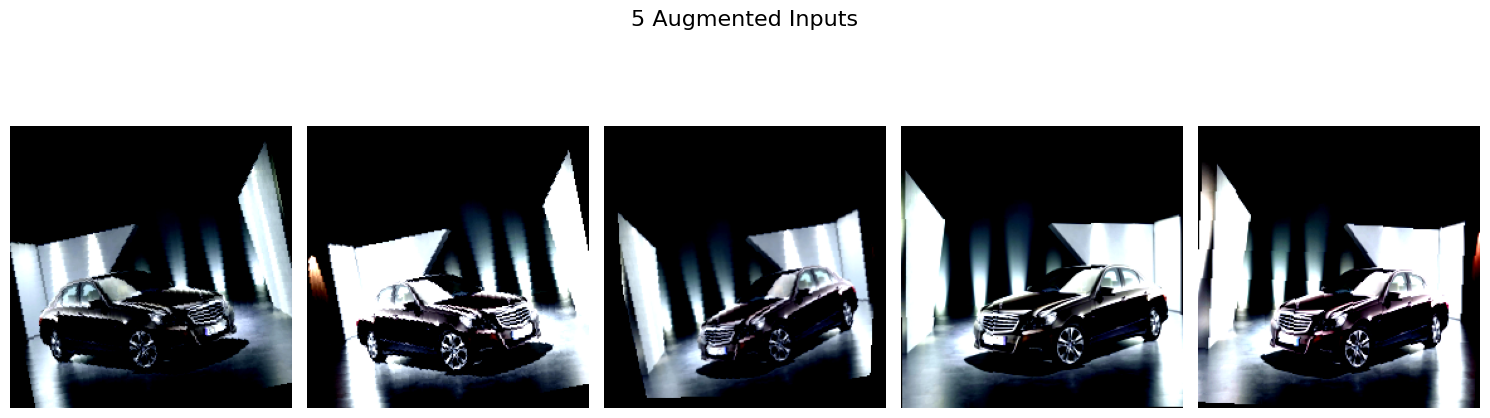


 Predictions for Each Augmented Image:
Image 1 predicted: Hyundai Genesis Sedan 2012
Image 2 predicted: Hyundai Genesis Sedan 2012
Image 3 predicted: Mercedes-Benz E-Class Sedan 2012
Image 4 predicted: Hyundai Genesis Sedan 2012
Image 5 predicted: Hyundai Genesis Sedan 2012

 Majority-vote prediction (5 augmented views):
 - Predicted: Hyundai Genesis Sedan 2012
 - Actual:    Mercedes-Benz E-Class Sedan 2012

 Looking up market value for: Hyundai Genesis Sedan 2012
 API request failed: 403 - {"statusCode":403,"message":"Out of call volume quota."}


In [82]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor_img):
    # Unnormalize image
    img = tensor_img.cpu() * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show 5 augmented images only 
plt.figure(figsize=(15, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i+1)
    imshow(img.squeeze(0))

plt.suptitle("5 Augmented Inputs", fontsize=16)
plt.tight_layout()
plt.show()

print("\n Predictions for Each Augmented Image:")
for i, pred_idx in enumerate(preds):
    label_name = test_dataset.dataset.classes[pred_idx]
    print(f"Image {i+1} predicted: {label_name}")


# 6. Majority vote
most_common_pred = Counter(preds).most_common(1)[0][0]
pred_class_name = test_dataset.dataset.classes[most_common_pred]
true_class_name = test_dataset.dataset.classes[label]

print(f"\n Majority-vote prediction (5 augmented views):")
print(f" - Predicted: {pred_class_name}")
print(f" - Actual:    {true_class_name}")

# 7. API call
print(f"\n Looking up market value for: {pred_class_name}")
run_vehicle_value_lookup(pred_class_name, mileage=85000, state="TX")

